# Challenge SD207 - 2017
*<p>Author: Pengfei MI, Rui SONG</p>*
*<p>Date: 06/06/2017</p>*

In [1]:
import numpy as np
import scipy as sp
from scipy.stats import mode
import pandas as pd
import matplotlib.pyplot as plt
from time import time

import librosa
import librosa.display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier

In [2]:
# Define some usefull functions
def load_sound_file(file_path):
    X, sr = librosa.load(file_path, sr=None)
    return X

def extract_feature(file_name): # Late fusion
    X, sample_rate = librosa.load(file_name, sr=None)
    #mfcc = librosa.feature.mfcc(y=librosa.effects.harmonic(X), sr=sample_rate, n_fft=4096, hop_length=2048, n_mfcc=n_mfcc).T
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_fft=4096, hop_length=2048, n_mfcc=n_mfcc).T
    mfcc_delta = librosa.feature.delta(mfcc, width=5, order=1, trim=True)
    return np.c_[mfcc[:, 1:], mfcc_delta]

def parse_audio_files(file_names, file_labels):
    features, labels = np.empty((0,n_mfcc*2-1)), np.empty(0)
    for fn, fl in zip(file_names, file_labels):
        try:
            mfcc = extract_feature(fn)
        except Exception as e:
            print "Error encountered while parsing file: ", fn
            continue
        features = np.vstack([features, mfcc])
        labels = np.append(labels, fl*np.ones(mfcc.shape[0]))
    return np.array(features), np.array(labels, dtype = np.int)

def predict(clf, X_test):
    y_pred = np.empty(0)
    y_pred_sum = np.empty(0)
    y_pred_prod = np.empty(0)
    for x in X_test:
        x_mfccs = extract_feature(x)
        y_predicts = clf.predict(x_mfccs)
        y_predict_probas = clf.predict_proba(x_mfccs)
        y_pred = np.append(y_pred, mode(y_predicts).mode[0])
        y_pred_sum = np.append(y_pred_sum, np.argmax(np.sum(y_predict_probas, axis=0)))
        y_pred_prod = np.append(y_pred_prod, np.argmax(np.prod(y_predict_probas, axis=0)))
    return np.array(y_pred, dtype=np.int), np.array(y_pred_sum, dtype=np.int), np.array(y_pred_prod, dtype=np.int)

def predict_maj(clf, X_test):
    y_pred = np.empty(0)
    for x in X_test:
        x_mfccs = extract_feature(x)
        y_predicts = clf.predict(x_mfccs)
        y_pred = np.append(y_pred, mode(y_predicts).mode[0])
    return np.array(y_pred, dtype = np.int)

def predict_sum(clf, X_test):
    y_pred = np.empty(0)
    for x in X_test:
        x_mfccs = extract_feature(x)
        y_predicts = np.sum(clf.predict_proba(x_mfccs), axis=0)
        y_pred = np.append(y_pred, np.argmax(y_predicts))
    return np.array(y_pred, dtype = np.int)

def predict_prod(clf, X_test):
    y_pred = np.empty(0)
    for x in X_test:
        x_mfccs = extract_feature(x)
        y_predicts = np.prod(clf.predict_proba(x_mfccs), axis=0)
        y_pred = np.append(y_pred, np.argmax(y_predicts))
    return np.array(y_pred, dtype = np.int)

def plot_wave(title, raw_sound):
    plt.close('all')
    plt.figure(figsize=(20,6))
    plt.title(title)
    librosa.display.waveplot(np.array(raw_sound), sr=16000)
    plt.show()
    
def plot_specgram(title,raw_sound):
    plt.close('all')
    plt.figure(figsize=(20,6))
    plt.title(title)
    plt.specgram(np.array(raw_sound), Fs=16000)
    plt.show()

def plot_log_power_specgram(title,raw_sound):
    plt.close('all')
    plt.figure(figsize=(20,6))
    plt.title(title)
    D = librosa.logamplitude(np.abs(librosa.stft(raw_sound))**2, ref_power=np.max)
    librosa.display.specshow(D, x_axis='time' ,y_axis='log')
    plt.specgram(np.array(f), Fs=16000)
    plt.show()

In [3]:
# Read data and preprocessing
print "Loading files..."
t0 = time()
FILEROOT = './'

files_train = pd.read_csv('train.txt', sep='\s+', header=None)[0].values
labels = np.unique(pd.read_csv('train.txt', sep='\s+', header=None)[1])
n_labels = len(labels)
labels_train = pd.factorize(pd.read_csv('train.txt', sep='\s+', header=None)[1])[0]
files_val = pd.read_csv('dev.txt', sep='\s+', header=None)[0].values
labels_val = pd.factorize(pd.read_csv('dev.txt', sep='\s+', header=None)[1])[0]
files_test = pd.read_csv('test_files.txt', header=None)[0].values

print "Training set size: %d" % len(files_train)
print "Validation set size: %d" % len(files_val)
print "Test set size: %d" % len(files_test)
print "Done in %0.3fs." % (time()-t0)

Loading files...
Training set size: 582
Validation set size: 290
Test set size: 298
Done in 0.013s.


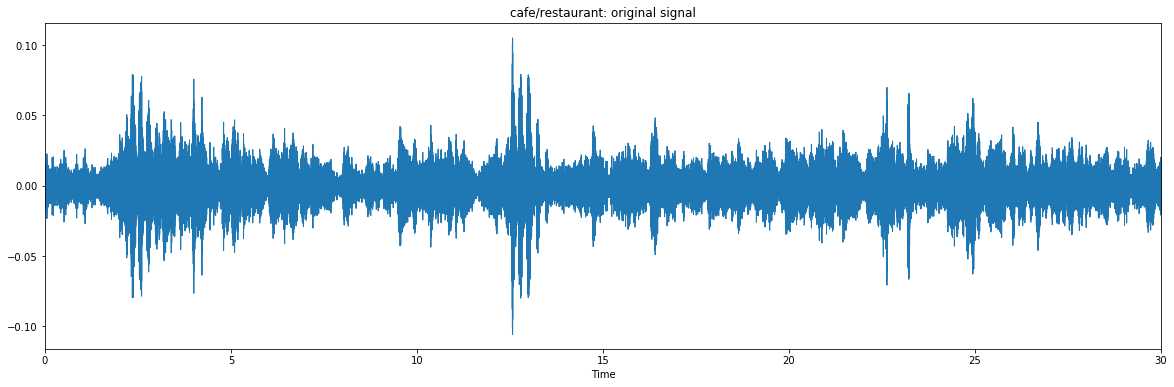

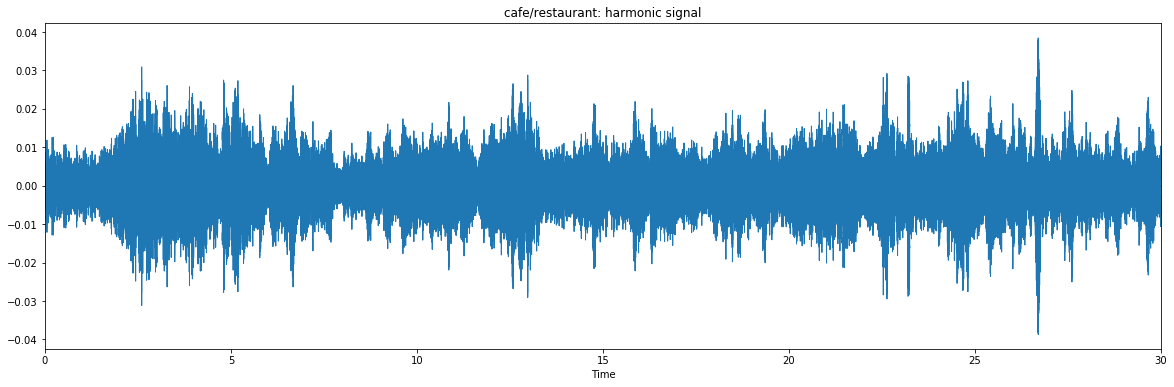

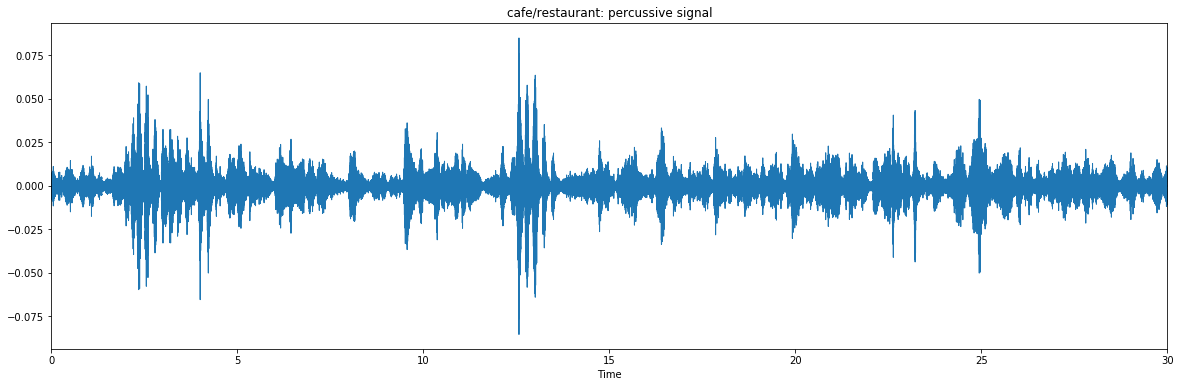

In [4]:
y = load_sound_file(files_train[42])
y_harmonic, y_percussive = librosa.effects.hpss(y)
plot_wave("%s: original signal" % labels[labels_train[42]], y)
plot_wave("%s: harmonic signal" % labels[labels_train[42]], y_harmonic)
plot_wave("%s: percussive signal" % labels[labels_train[42]], y_percussive)

In [5]:
# Feature extraction
print "Extracting features..."
n_mfcc = 20
t0 = time()
X_train, y_train = parse_audio_files(files_train, labels_train)
print X_train.shape, y_train.shape
print "Done in %0.3fs." % (time()-t0)

Extracting features...
(136770, 39) (136770,)
Done in 32.133s.


In [6]:
# Train classifier
print "Training classifier..."
np.random.seed(42)
t0 = time()
clf = SVC(C=1, gamma=0.1)
clf.fit(X_train, y_train)
print "Done in %0.3fs." % (time()-t0)

Training classifier...
Done in 8405.843s.


In [ ]:
# Predicting on validation set...
t0 = time()
y_val_pred = predict_maj(clf, files_val)
print "Score on validation test (vote by majority): %f" % np.mean(y_val_pred == labels_val)
print classification_report(labels_val, y_val_pred, target_names=labels)

Score on validation test (vote by majority): 0.062069
                  precision    recall  f1-score   support

           beach       0.00      0.00      0.00        21
             bus       0.00      0.00      0.00        20
 cafe/restaurant       0.00      0.00      0.00        19
             car       0.00      0.00      0.00        19
     city_center       0.00      0.00      0.00        19
     forest_path       0.06      1.00      0.12        18
   grocery_store       0.00      0.00      0.00        21
            home       0.00      0.00      0.00        18
         library       0.00      0.00      0.00        18
   metro_station       0.00      0.00      0.00        18
          office       0.00      0.00      0.00        23
            park       0.00      0.00      0.00        18
residential_area       0.00      0.00      0.00        21
           train       0.00      0.00      0.00        19
            tram       0.00      0.00      0.00        18

     avg / total

/Applications/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
y_test_pred = predict_maj(clf, files_test)
np.savetxt('y_test_pred_delta_mfcc_svm2.txt', y_test_pred, fmt='%d')
print y_test_pred